In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from tqdm import tqdm

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))

def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)

def convert(fin):
    red = fin.read(3)
    green = fin.read(2)
    blue = fin.read(1)

    red_b = brighten(red)
    blue_b = brighten(blue)
    green_b = brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    return np.dstack((red_bn, green_bn, blue_bn))

In [2]:
# Создаем модель UNET для сегментации изображений.
# Мы немного поэксперементировали, и по итогам эксперементов добавили в классический UNET блоки внимания для того чтобы
# фокусироваться на наиболее информативных частях изображения, быстрее сходиться и показывать более лучшую сегментацию.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1),
            nn.BatchNorm2d(in_channels // 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )
        self.down5 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(1024, 2048)
        )

        self.attention1 = AttentionBlock(2048)
        self.attention2 = AttentionBlock(1024)
        self.attention3 = AttentionBlock(512)
        self.attention4 = AttentionBlock(256)
        self.attention5 = AttentionBlock(128)

        self.up1 = nn.ConvTranspose2d(2048, 1024, 2, stride=2)
        self.up_conv1 = DoubleConv(2048, 1024)
        self.up2 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up_conv2 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)
        self.up4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv4 = DoubleConv(256, 128)
        self.up5 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv5 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        
        x6 = self.attention1(x6)
        x6 = self.dropout(x6)
        
        x = self.up1(x6)
        x5 = self.attention2(x5)
        x = torch.cat([x, x5], dim=1)
        x = self.up_conv1(x)
        x = self.dropout(x)
        
        x = self.up2(x)
        x4 = self.attention3(x4)
        x = torch.cat([x, x4], dim=1)
        x = self.up_conv2(x)
        x = self.dropout(x)
        
        x = self.up3(x)
        x3 = self.attention4(x3)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv3(x)
        
        x = self.up4(x)
        x2 = self.attention5(x2)
        x = torch.cat([x, x2], dim=1)
        x = self.up_conv4(x)
        
        x = self.up5(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv5(x)
        
        logits = self.outc(x)
        return logits

# Инициализация модели
model = UNet(n_channels=6, n_classes=2)

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [3]:
# Загружаем модель
model = UNet(n_channels=6, n_classes=2)
model.load_state_dict(torch.load('model_4.pth'))
model.eval()  

print("Модель UNet успешно загружена из файла 'model.pth'")

model.to('cuda')
pass

/tmp/ipykernel_773644/563314612.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_4.pth'))


Модель UNet успешно загружена из файла 'model.pth'


In [4]:
import rasterio
import numpy as np
import torch
from torch.nn.functional import pad
import matplotlib.pyplot as plt
from tqdm import tqdm

# Разбиваем изображение на куски размером 256х256 с шагом 128 и строим маски для каждого куска по отдельности

def calculate_ndwi(green, nir):
    return (green - nir) / (green + nir + 1e-6) 

normalization_params = {
    'means': np.array([ 379.32272921,  559.31295475, 1681.15083572, 2066.72689497,
        1774.60624368,   27.08799462]),
    'stds': np.array([270.54608327, 267.30903042, 687.08251987, 916.49339797,
        666.09729757,  12.64723763])}

def predict_large_image(model, tif_data, window_size=256, stride=128, batch_size=64):
    image = tif_data.read([1, 2, 5, 7, 9])  # Берем только каналы B02, B03, B06, B08, B11
    height, width = image.shape[1], image.shape[2]
    
    # Расчет NDWI
    ndwi = calculate_ndwi(image[1], image[3])
    image = np.concatenate([image, ndwi[np.newaxis, ...]], axis=0)
    
    # Нормализация
    means = np.array(normalization_params['means'])[:, np.newaxis, np.newaxis]
    stds = np.array(normalization_params['stds'])[:, np.newaxis, np.newaxis]
    image = (image - means) / stds
    
    # Создаем выходную маску
    prediction = np.zeros((height, width), dtype=np.float32)
    counts = np.zeros((height, width), dtype=np.float32)

    # Переводим модель в режим оценки и на нужное устройство
    model.eval()
    device = next(model.parameters()).device

    windows = []
    positions = []
    total_windows = ((height - window_size) // stride + 1) * ((width - window_size) // stride + 1)
    
    with tqdm(total=total_windows, desc="Обработка окон") as pbar:
        for y in range(0, height - window_size + 1, stride):
            for x in range(0, width - window_size + 1, stride):
                window = image[:, y:y+window_size, x:x+window_size]
                windows.append(window)
                positions.append((y, x))
                
                if len(windows) == batch_size:
                    batch = torch.from_numpy(np.array(windows)).float().to(device)
                    batch = batch.permute(0, 1, 2, 3)
                    
                    with torch.no_grad():
                        output = model(batch)
                        output = torch.argmax(output, dim=1)  
                    
                    for (y, x), pred in zip(positions, output):
                        prediction[y:y+window_size, x:x+window_size] += pred.cpu().numpy()
                        counts[y:y+window_size, x:x+window_size] += 1
                    
                    windows = []
                    positions = []
                    
                    pbar.update(batch_size)
    
        if windows:
            batch = torch.from_numpy(np.array(windows)).float().to(device)
            batch = batch.permute(0, 1, 2, 3)
            with torch.no_grad():
                output = model(batch)
                output = torch.argmax(output, dim=1)
            for (y, x), pred in zip(positions, output):
                prediction[y:y+window_size, x:x+window_size] += pred.cpu().numpy()
                counts[y:y+window_size, x:x+window_size] += 1
            
            pbar.update(len(windows))

    prediction = np.divide(prediction, counts, where=counts != 0)
    prediction = np.round(prediction).astype(int)
    
    return prediction



In [5]:
import requests
import xml.etree.ElementTree as ET
import json

def fetch_osm_data(bbox):
    # Формирование URL на основе координат
    url = f'https://api.openstreetmap.org/api/0.6/map?bbox={bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}'

    # Определяем стоимость для разных типов зданий
    costs = {
        'house': 50000,
        'detached': 50000,
        'yes': 50000,
        'ruins': 30000,
        'retail': 130000,
        'church': 180000,
        'school': 200000,
        'service': 110000,
        'warehouse': 140000,
        'apartments': 160000,
        'hotel': 170000,
        'industrial': 250000,
        'garages': 50000,
        'kindergarten': 150000,
        'hospital': 210000,
        'public': 130000,
        'office': 150000,
        'college': 160000,
        'clinic': 120000,
        'mosque': 180000,
        'construction': 80000,
        'commercial': 140000,
        'unknown': 10000
    }

    # Инициализация переменных для подсчета и ущерба
    total_damage = 0
    damaged_objects = []
    object_counts = {}  # Словарь для подсчета объектов

    try:
        response = requests.get(url)
        if response.status_code == 200:
            root = ET.fromstring(response.content)

            # Словарь для узлов (id: (lat, lon))
            node_dict = {
                node.get('id'): (float(node.get('lat')), float(node.get('lon')))
                for node in root.findall('node')
            }

            # Обработка узлов и путей
            elements = root.findall('node') + root.findall('way')
            for elem in tqdm(elements, desc="Обработка элементов OSM"):
                if elem.tag == 'node':
                    tags = {tag.get('k'): tag.get('v') for tag in elem.findall('tag')}
                    if tags:
                        obj_type = tags.get("building", "unknown")
                        obj = {
                            "id": elem.get('id'),
                            "lat": node_dict[elem.get('id')][0],
                            "lon": node_dict[elem.get('id')][1],
                            "type": obj_type,
                            "estimated_damage": costs.get(obj_type, 100000)
                        }
                        total_damage += obj["estimated_damage"]
                        damaged_objects.append(obj)
                        object_counts[obj_type] = object_counts.get(obj_type, 0) + 1

                elif elem.tag == 'way':
                    tags = {tag.get('k'): tag.get('v') for tag in elem.findall('tag')}
                    obj_type = tags.get("building", "unknown")

                    way_obj = {
                        "id": elem.get('id'),
                        "nodes": [nd.get('ref') for nd in elem.findall('nd')],
                        "type": obj_type,
                    }

                    # Усреднение координат узлов в пути
                    lat_sum, lon_sum, count = 0, 0, 0
                    for nd in way_obj["nodes"]:
                        if nd in node_dict:
                            lat, lon = node_dict[nd]
                            lat_sum += lat
                            lon_sum += lon
                            count += 1

                    if count > 0:
                        avg_lat = lat_sum / count
                        avg_lon = lon_sum / count
                        way_obj["lat"] = avg_lat
                        way_obj["lon"] = avg_lon
                        way_obj["estimated_damage"] = costs.get(obj_type, 100000)

                        total_damage += way_obj["estimated_damage"]
                        damaged_objects.append(way_obj)
                        object_counts[obj_type] = object_counts.get(obj_type, 0) + 1

            # Формирование JSON-выходных данных
            output_data = {
                "infrastructure": damaged_objects,
                "all_damage": total_damage,
                "object_counts": object_counts  # Добавляем количество объектов
            }

            # Сохранение в файл
            with open("osm_objects.json", "w") as json_file:
                json.dump(output_data, json_file, indent=4)

            print(len(output_data['infrastructure']))
            print("Данные успешно сохранены в 'osm_objects.json'")

            return output_data  # Возвращаем JSON-данные

        else:
            print(f"Ошибка при запросе данных: {response.status_code}")
            print(response.content)
            return None
    except requests.RequestException as e:
        print(f"Произошла ошибка запроса: {e}")
        return None


Обработка окон: 100%|██████████| 703/703 [00:05<00:00, 119.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..77.2].


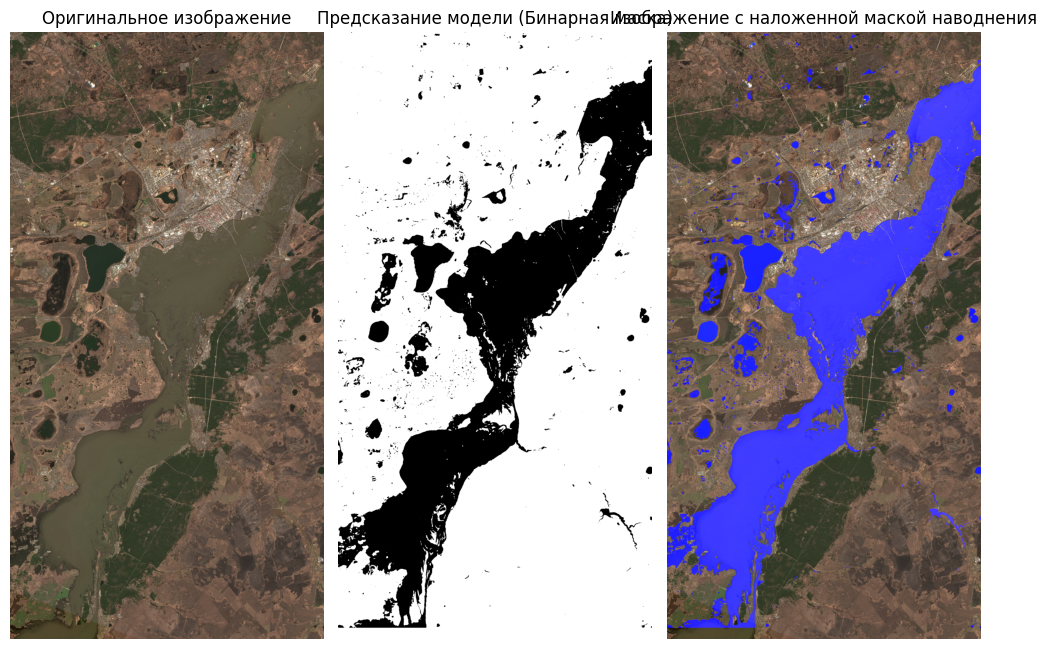

In [6]:
image_path = './test_scoltech/images/2.tif'

tif = rasterio.open(image_path)

prediction = predict_large_image(model, tif)

# Чтение оригинального изображения
original_image = convert(tif)

# Создание маски наводнения
flood_mask = np.zeros_like(original_image)
flood_mask[:,:,2] = prediction * 255  # Синий канал для воды

# Наложение маски на оригинальное изображение
masked_image = original_image.copy()
masked_image[prediction == 1] = masked_image[prediction == 1] * 0.7 + flood_mask[prediction == 1] * 0.3

# Визуализация результата
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Оригинальное изображение
ax1.imshow(original_image)
ax1.set_title('Оригинальное изображение')
ax1.axis('off')

# Предсказание модели
ax2.imshow(prediction, cmap='binary')
ax2.set_title('Предсказание модели (Бинарная маска)')
ax2.axis('off')

# Изображение с наложенной маской
ax3.imshow(masked_image)
ax3.set_title('Изображение с наложенной маской наводнения')
ax3.axis('off')

plt.tight_layout()
plt.show()

Обработка элементов OSM: 100%|██████████| 30561/30561 [00:00<00:00, 533831.94it/s]


5065
Данные успешно сохранены в 'osm_objects.json'


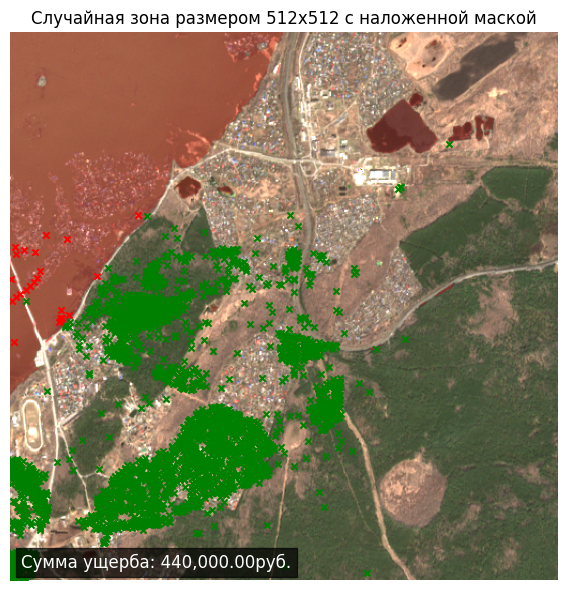

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
# Проверяем, что размеры изображения и маски совпадают
assert original_image.shape[:2] == prediction.shape, "Размеры изображения и маски не совпадают"

# Выбираем случайный кусочек изображения размером 512x512
h, w = original_image.shape[:2]
top = np.random.randint(0, h - 512)
left = np.random.randint(0, w - 512)
sample_image = original_image[top:top+512, left:left+512]
sample_mask = prediction[top:top+512, left:left+512]

# Получаем координаты выбранного кусочка
window = rasterio.windows.Window(left, top, 512, 512)
window_transform = rasterio.windows.transform(window, tif.transform)
sample_bounds = rasterio.transform.array_bounds(512, 512, window_transform)
sample_bbox = list(sample_bounds)

# Получаем данные OSM для выбранного кусочка
sample_osm_data = fetch_osm_data(sample_bbox)

estimated_damage = 0

# Создание фигуры для отображения
plt.figure(figsize=(12, 6))

# Нормализация и корректировка цветов изображения
sample_image_rgb = sample_image[:, :, :3]  # Берем только первые три канала (RGB)
sample_image_rgb = sample_image_rgb.astype(np.float32) / sample_image_rgb.max()  # Нормализация
sample_image_rgb = np.clip(sample_image_rgb * 1.5, 0, 1)  # Увеличиваем яркость

# Отображаем изображение
plt.imshow(sample_image_rgb)

# Накладываем маску, заштрихованную слегка красным
mask_overlay = np.zeros((512, 512, 4), dtype=np.uint8)
mask_overlay[sample_mask == 1] = [255, 0, 0, 64]  # Красный цвет с альфа-каналом 0.25
plt.imshow(mask_overlay)

plt.title('Случайная зона размером 512x512 с наложенной маской')
plt.axis('off')

# Отображаем объекты на выбранном кусочке изображения
if sample_osm_data:
    for obj in sample_osm_data['infrastructure']:
        lat, lon = obj['lat'], obj['lon']
        # Преобразование географических координат в пиксельные
        row, col = ~tif.transform * (lon, lat)
        row, col = int(row) - top, int(col) - left

        # Проверка, что индексы находятся в допустимых пределах
        if 0 <= row < 512 and 0 <= col < 512:
            if sample_mask[row, col] == 1:  # Затопленный
                plt.scatter(col, row, color='red', marker='x', s=20, zorder=3)  # Красные крестики для затопленных объектов
                estimated_damage += obj['estimated_damage']
            else:  # Не затопленный
                plt.scatter(col, row, color='green', marker='x', s=20, zorder=3)  # Зеленые крестики для не затопленных объектов

# Добавляем текст с оценкой ущерба на график
plt.text(10, 500, f'Сумма ущерба: {estimated_damage:,.2f}руб.', 
         color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

In [ ]:
################################3

# НИЖЕ КОД ДЛЯ СОЗДАНИЯ САБМИТА.

In [7]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm

test_folder = './test_scoltech/images'

output_folder = './test_scoltech/masks'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

tif_files = [f for f in os.listdir(test_folder) if f.endswith('.tif')]

for tif_file in tqdm(tif_files, desc="Обработка изображений"):
    image_path = os.path.join(test_folder, tif_file)
    
    # Открываем изображение
    with rasterio.open(image_path) as tif:
        # Получаем предсказание модели
        prediction = predict_large_image(model, tif)
        
        # Создаем имя файла для маски
        mask_filename = f"{os.path.splitext(tif_file)[0]}_mask.tif"
        mask_path = os.path.join(output_folder, mask_filename)
        
        # Сохраняем маску в формате GeoTIFF
        with rasterio.open(
            mask_path,
            'w',
            driver='GTiff',
            height=prediction.shape[0],
            width=prediction.shape[1],
            count=1,
            dtype=prediction.dtype,
            crs=tif.crs,
            transform=tif.transform,
        ) as dst:
            dst.write(prediction, 1)

print("Обработка завершена. Маски сохранены в папке:", output_folder)


Обработка изображений: 100%|██████████| 4/4 [00:27<00:00,  6.87s/it]

Обработка завершена. Маски сохранены в папке: ./test_scoltech/masks


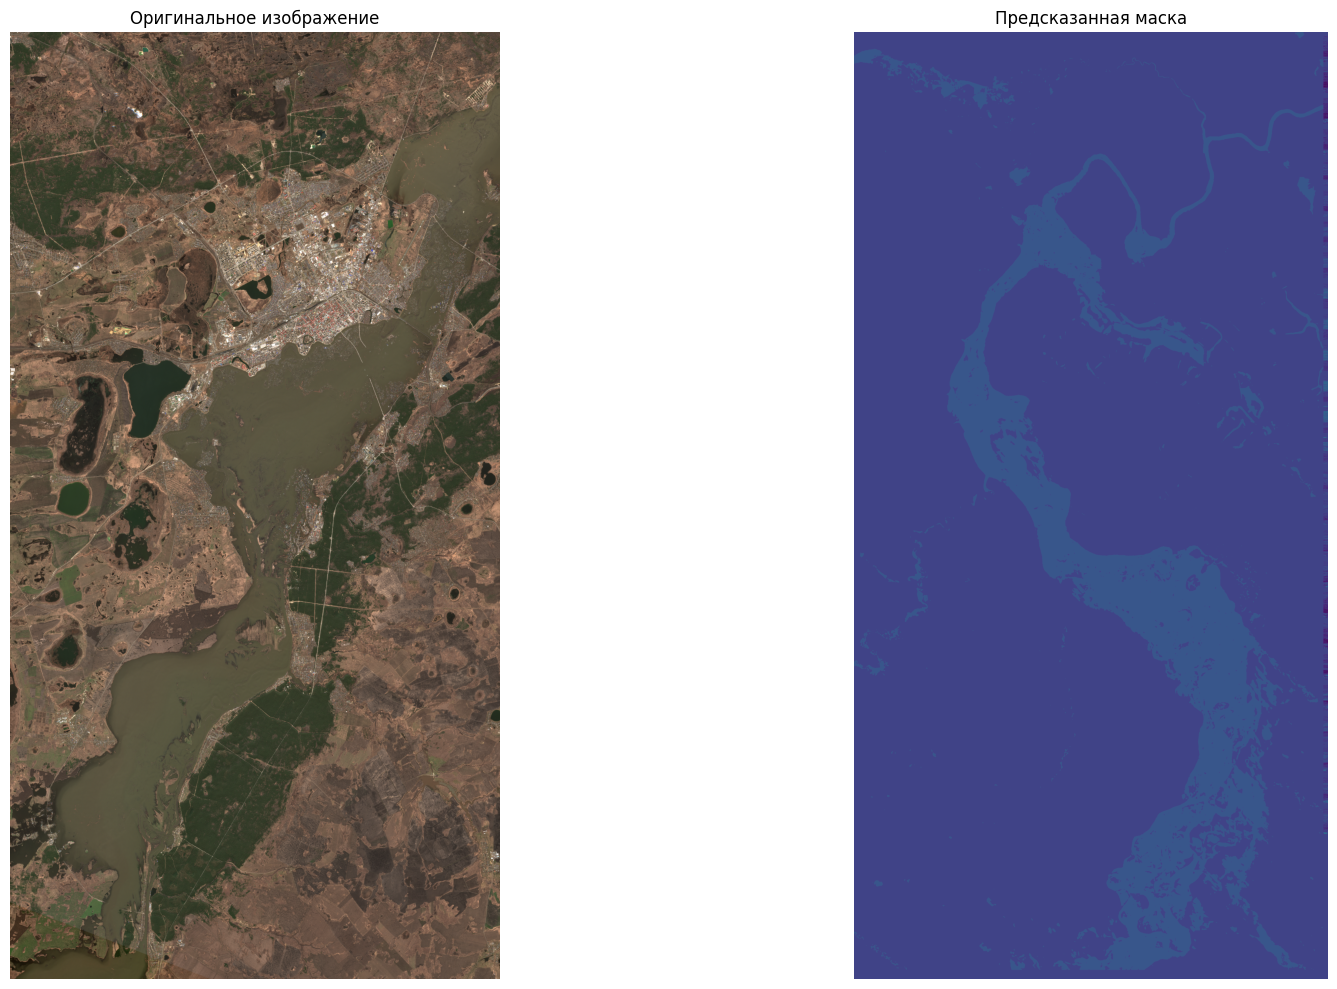

Размер оригинального изображения: (4956, 2560, 3)
Размер маски: (4911, 2456)


In [10]:
# Открываем файл с сохраненной маской
mask_filename = f"{os.path.splitext(tif_file)[0]}_mask.tif"
mask_path = os.path.join(output_folder, mask_filename)

with rasterio.open(mask_path) as src:
    mask = src.read(1)

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Отображаем оригинальное изображение
ax1.imshow(original_image[:, :, :3])  # Используем только первые три канала для RGB
ax1.set_title('Оригинальное изображение')
ax1.axis('off')

# Отображаем маску
ax2.imshow(mask, cmap='viridis')
ax2.set_title('Предсказанная маска')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Выводим информацию о размерах
print(f"Размер оригинального изображения: {original_image.shape}")
print(f"Размер маски: {mask.shape}")
